<a href="https://colab.research.google.com/github/Thataag/Projeto1PUC/blob/main/novabase_Thalita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install pandas

Esse foi meu primeiro contato com Machine Learning e com atividade desse tipo. Escolhi essa base pela aproximação que possui com meu trabalho.

Trabalho em banco e meu dataset escolhido foi uma campanha de um Banco para oferta de um produto investimento(Depósito a prazo).

Quero criar um modelo de aprendizado supervisionado para um problema de classificação binário, ou seja, um modelo que preveja quais clientes contratarão o produto.

O conjunto de dados possui os seguintes atributos:

age(idade),
job(Profissão),
marital(estado civil),
education(nível de escolaridade),
default(se tem crédito inadimplente),
balance(saldo médio anual em euro),
housing(se tem financiamento imobiliário),
loan(se tem empréstimo pessoal),
contact(tipo de contato),
day(último dia de contato no mês),
month(último mês de contato no ano),
duration(duração do último contato em segundos),
campaign(número de contatos realizados durante esta campanha para cada cliente),
pdays(número de dias que se passaram desde que o cliente foi contatado pela última vez em uma campanha anterior),
previous(número de contatos realizados antes desta campanha e para cada cliente),
poutcome(resultado da campanha de marketing anterior),
e deposit(se o cliente contratou o produto ou não).




In [28]:
# Primeiramente, carregando o conjunto de dados. Importando bibliotecas.
import pandas as pd
import numpy as np

# Importando visualização padrão.
import matplotlib.pyplot as plt
import seaborn as sns

Carregando dataset através de um arquivo que chamei de "arquivo".

Quero ao final, que o modelo prediga quem irá contratar o produto investimento ofertado pelo banco na campanha de marketing( clientes que subscreverão depósitos à prazo).

Para ficar mais claro, renomeei a coluna "deposit" que passará a se chamar "contracted".


In [29]:
# Dataset "arquivo".
arquivo = pd.read_csv('https://raw.githubusercontent.com/Thataag/Projeto1PUC/main/base/bank.csv')

arquivo = arquivo.rename(columns={'deposit': 'contracted'})

# Verificando como ficou.

arquivo.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,contracted
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [30]:
# Consultando para ver se a base possui algum registro em branco. Como não possui, seguirei para análise dos atributos na sequência.

missing_values = arquivo.isnull().mean()*100

missing_values.sum()

0.0

Minha base possui colunas categóricas e numéricas. Vou analisar primeiramente as colunas categóricas gerando gráficos para melhor interpretação.

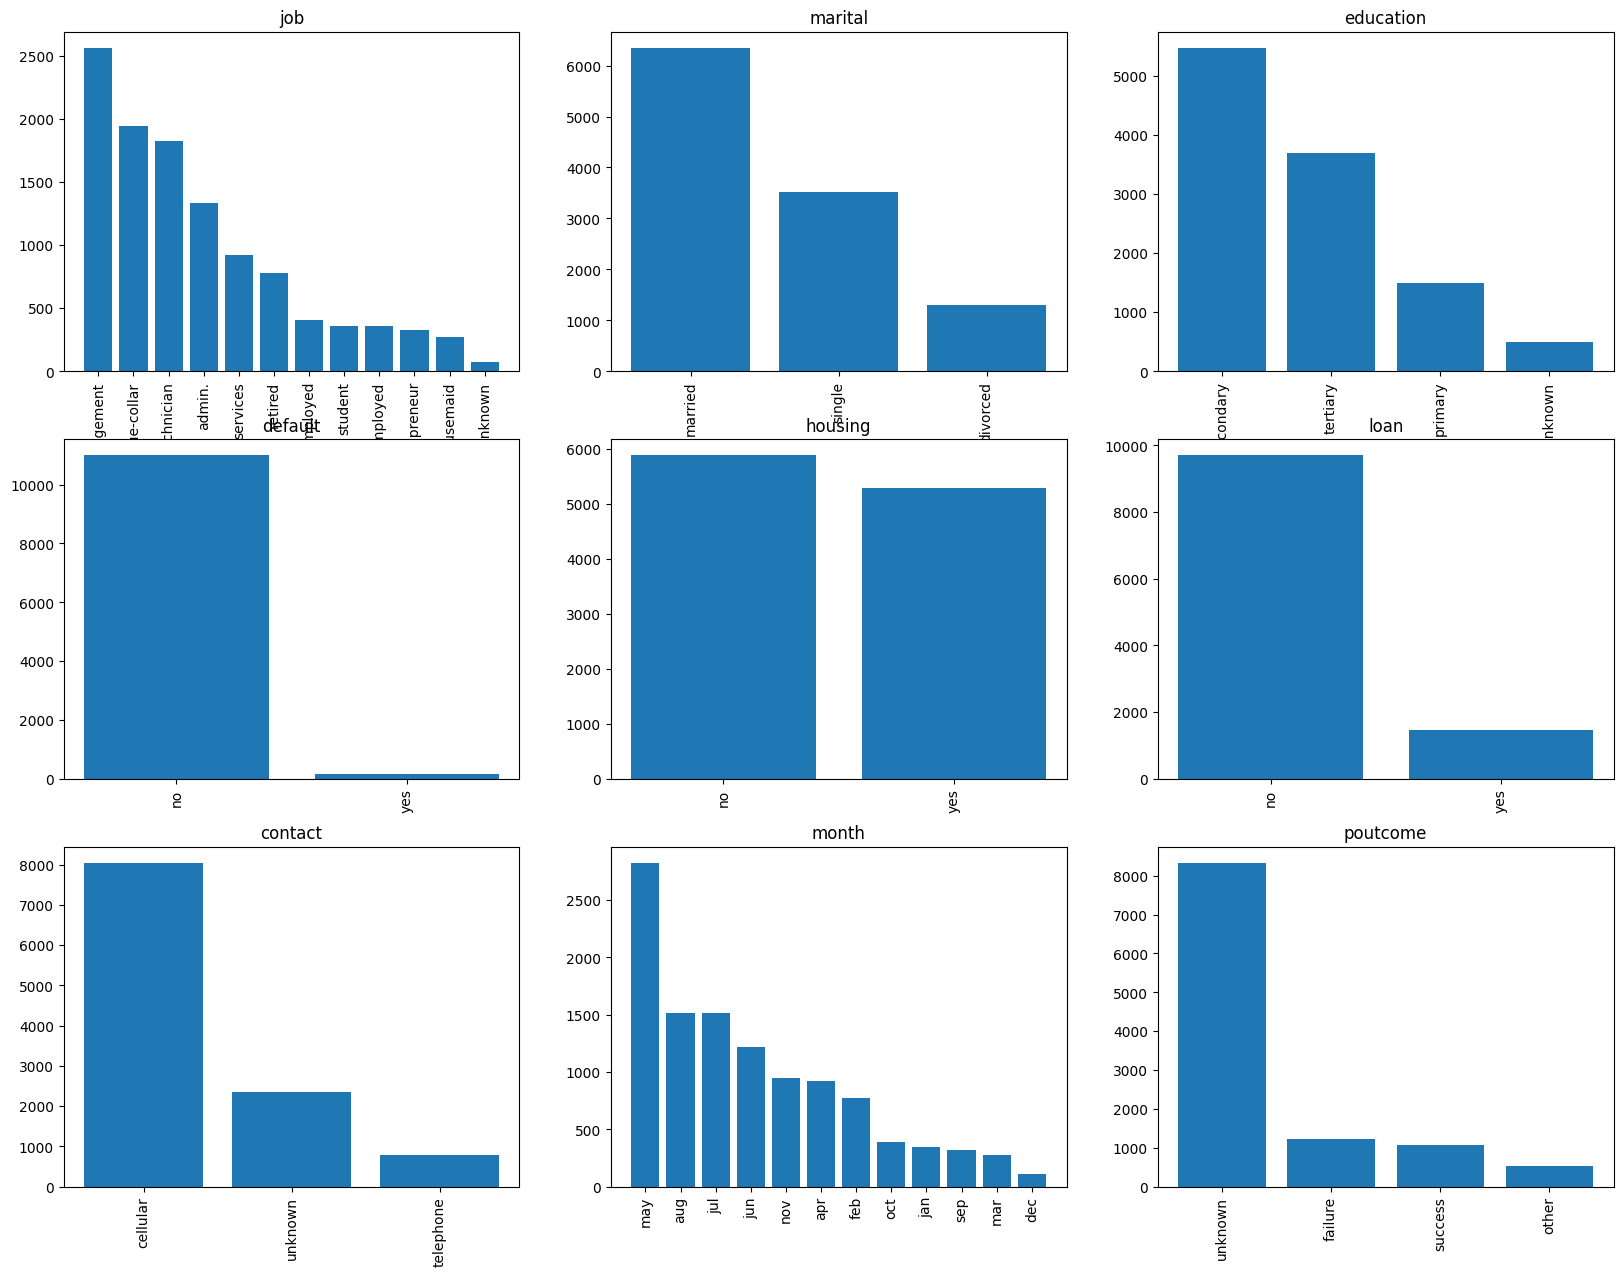

In [31]:
# Discriminando colunas categóricas.

cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Configurando os gráficos.

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for cat_column in cat_columns:
    value_counts = arquivo[cat_column].value_counts()

    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))

    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)

    axs[trace_x, trace_y].set_title(cat_column)

    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)

    counter += 1

plt.show()

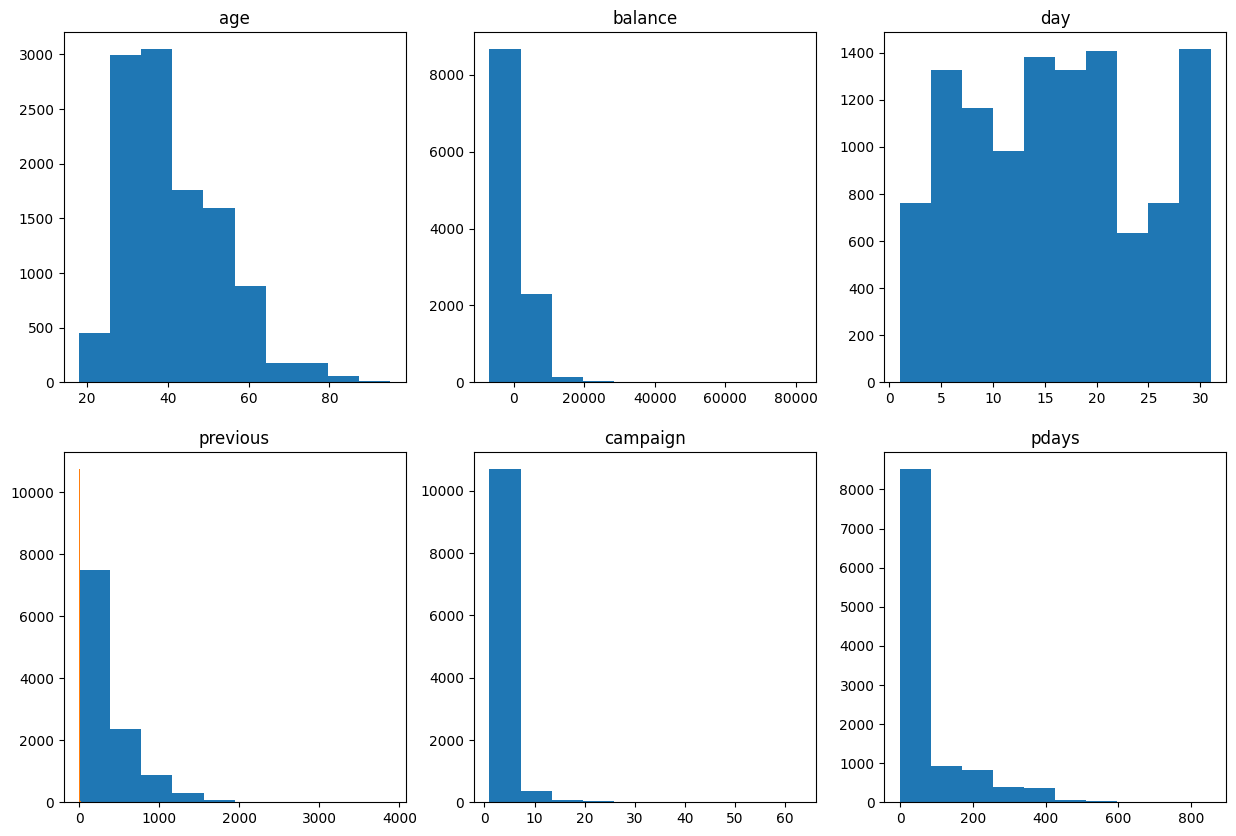

In [32]:
# Analisando as colunas numéricas por meio de histogramas.

num_columns = ['age','balance','day', 'duration','campaign','pdays', 'previous']

fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(15, 10))

counter = 0
for num_column in num_columns:

    trace_x = counter // 3
    if trace_x > 1:
        trace_x = 1
    trace_y = counter % 3

    axs[trace_x, trace_y].hist(arquivo[num_column])

    axs[trace_x, trace_y].set_title(num_column)

    counter += 1

plt.show()

In [33]:
# Analisando as colunas 'campaign'e 'previous'. Possuem muita discrepância.

arquivo[['campaign', 'previous']].describe()

,campaign,previous
count,11162.000000,11162.000000
mean,2.508421,0.832557
std,2.722077,2.292007
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,1.000000
max,63.000000,58.000000


A Coluna "campaign" indica os contatos realizados durante a campanha. Observei que os valores acima de 33 são ruídos.
Vou imputar valores médios de campanha, portanto, ao tratar valores acima de 33 nessa coluna.

A coluna "previous" indica os contatos efetuados previamente a esta campanha. Também observei que valores acima de 33 são destoantes.
Vou imputar valores médios de contatos prévios, portanto, ao tratar valores acima de 33 nessa coluna.

In [34]:
# Analisando a coluna 'campaign'.

len (arquivo[arquivo['campaign'] > 33]) / len(arquivo) * 100

0.035835871707579285

In [35]:
# Analisando coluna 'previous'.

len (arquivo[arquivo['previous'] > 33] ) / len(arquivo) * 100

0.04479483963447411

Observando a coluna 'contracted': Os valores são bem equilibrados, portanto, a acurácia pode ser uma boa opção de métrica para modelo de previsão da campanha de marketing.


<Axes: title={'center': 'Deposit contracted'}, xlabel='contracted'>

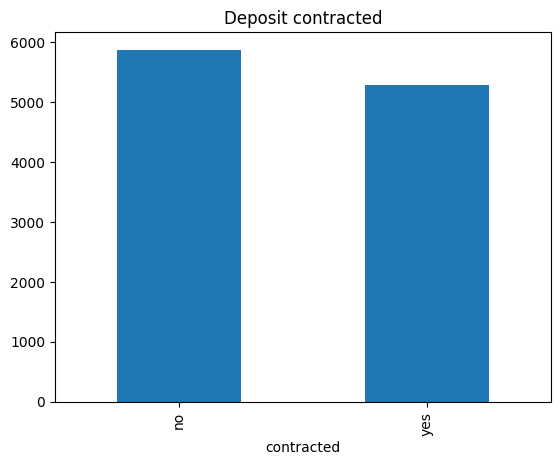

In [36]:
# Analisando a coluna de resposta.
value_counts = arquivo['contracted'].value_counts()

value_counts.plot.bar(title = 'Deposit contracted')

A seguir, vou tratar a base, preparando conjunto de dados para processo:

Primeiro, criando função para receber uma linha do dataframe e o nome da coluna, se o valor na coluna especificada for "yes", retorna 1; caso contrário, retorna 0.

Em seguida, criando função para receber linha do dataframe, nome da coluna, um limite e o dataframe. Se o valor da referida coluna for inferior ou igual ao limite, retorna o próprio valor . Se não for, a função calcula a média dos valores menores ou iguais ao limite da referida coluna e retorna esse valor médio.

Depois, fazendo a limpeza da base. Função para receber o dataframe (arquivo) contendo um conjunto de dados de campanha bancária e retornar um dataframe limpo. Cria uma cópia do dataframe original (cleaned_arquivo).

Por fim, transformando colunas categóricas em numéricas:
Fazendo coversão de sim/não para boleanas e fazendo codificação one-hot de todas as demais colunas categóricas especificadas na lista "cat_columns" e atualizando o DataFrame "cleaned_arquivo" com as novas colunas dummy.

Fiz ainda, o tratamento das colunas 'campaign' e 'previous':
Alterando valores destoantes das colunas "campaign" e "previous" e descartando as colunas originais, conforme a análise que fiz anteriormente sobre os valores acima de 33.

In [37]:
# Preparando conjunto de dados para processo.


def get_dummy_from_bool(row, column_name):
    return 1 if row[column_name] == 'yes' else 0


def get_correct_values(row, column_name, threshold, df):

    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = arquivo[arquivo[column_name] <= threshold][column_name].mean()
        return mean

# Fazendo a limpeza da base.

def clean_data(arquivo):

    cleaned_arquivo = arquivo.copy()

# Convertendo colunas sim/não em boleanas
    bool_columns = ['contracted', 'housing', 'loan', 'default']
    for bool_col in bool_columns:
        cleaned_arquivo[bool_col + '_bool'] = arquivo.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)

    cleaned_arquivo = cleaned_arquivo.drop(columns = bool_columns)

# Convertendo colunas categóricas em variáveis ​​fictícias (dummy).

    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

    for col in  cat_columns:
      cleaned_arquivo = pd.concat(
        [
          cleaned_arquivo.drop(col, axis=1),
          pd.get_dummies(
              cleaned_arquivo[col],
              prefix=col,
              prefix_sep='_',
              drop_first=True,
              dummy_na=False
          )
        ],
        axis=1
      )

# Deletando colunas que considerei irrelevante por ser bastante discrepante e ruidosa.
    cleaned_arquivo = cleaned_arquivo.drop(columns = ['pdays'])

# Alterando valores destoantes das colunas "campaign" e "previous"
    cleaned_arquivo['campaign_cleaned'] = arquivo.apply(lambda row: get_correct_values(row, 'campaign', 33, cleaned_arquivo),axis=1)
    cleaned_arquivo['previous_cleaned'] = arquivo.apply(lambda row: get_correct_values(row, 'previous', 33, cleaned_arquivo),axis=1)

    cleaned_arquivo = cleaned_arquivo.drop(columns = ['campaign', 'previous'])

    return cleaned_arquivo

In [38]:
# Limpando o dataset e conferindo.
cleaned_arquivo = clean_data(arquivo)
cleaned_arquivo.head()

,age,balance,day,duration,contracted_bool,housing_bool,loan_bool,default_bool,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,campaign_cleaned,previous_cleaned
0,59,2343,5,1042,1,1,0,0,False,False,...,False,True,False,False,False,False,False,True,1.0,0.0
1,56,45,5,1467,1,0,0,0,False,False,...,False,True,False,False,False,False,False,True,1.0,0.0
2,41,1270,5,1389,1,1,0,0,False,False,...,False,True,False,False,False,False,False,True,1.0,0.0
3,55,2476,5,579,1,1,0,0,False,False,...,False,True,False,False,False,False,False,True,1.0,0.0
4,54,184,5,673,1,0,0,0,False,False,...,False,True,False,False,False,False,False,True,2.0,0.0


<Axes: title={'center': 'Contracted Result'}, xlabel='contracted_bool'>

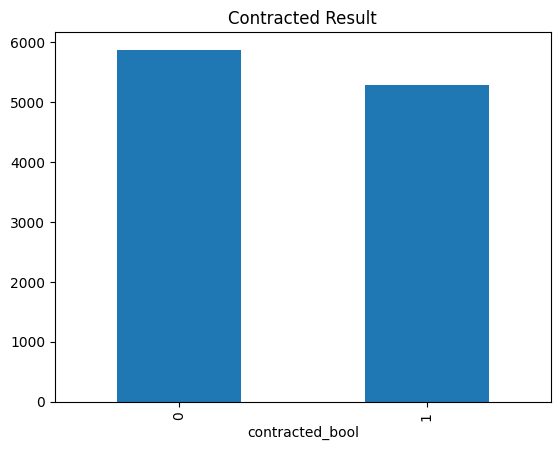

In [39]:
# Verificando os valores da coluna "contracted_bool" do dataframe "cleaned_arquivo" e gerando gráfico para melhor interpretação.

value_counts = cleaned_arquivo['contracted_bool'].value_counts()

value_counts.plot.bar(title = 'Contracted Result')

Separando as variáveis entre preditoras e variável alvo:

In [40]:
# Variáveis preditoras e variável alvo.
y = cleaned_arquivo['contracted_bool']
x = cleaned_arquivo.drop('contracted_bool', axis = 1)

Abaixo:
Criando conjunto de dados de treino e teste. Usarei 30% dos dados para teste e 70% para treinamento e parâmentro random_state 42.
Importando a função train_test_split do módulo model_selection da biblioteca Scikit-learn.

In [41]:
# Criando conjunto de dados de treino e teste.

from sklearn.model_selection import train_test_split

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.3, random_state = 42)

Para meu problema de classificação binária, penso inicialmente que seja interessante a Regressão Logística, mas vou testar também outros algoritmos.

In [42]:
# Importando ExtraTreesClassifier, LogisticRegression e GradientBoostingClassifier.

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

Criação do modelo ExtraTreesClassifier e exibindo a acurácia:

In [43]:
modelo = ExtraTreesClassifier()
modelo.fit(x_treino, y_treino)

# Imprimindo resultados
resultado = modelo.score(x_teste, y_teste)

# Convertendo o resultado para %
acuracia_percentual = resultado * 100

# Arredondando o resultado para duas casas decimais
acuracia_percentual_arredondada = round(acuracia_percentual, 2)

# Exibindo a acurácia em porcentagem com duas casas decimais
print('Acurácia:', acuracia_percentual_arredondada, '%')

Acurácia: 82.17 %


Criação do modelo ExtraTreesClassifier utilizando número de estimadores para quantidade de árvores de decisão (100) e exibindo a acurácia:

In [44]:
modelo = ExtraTreesClassifier(n_estimators=100)
modelo.fit(x_treino, y_treino)

# Imprimindo resultados
resultado = modelo.score(x_teste, y_teste)

# Convertendo o resultado para %
acuracia_percentual = resultado * 100

# Arredondando o resultado para duas casas decimais
acuracia_percentual_arredondada = round(acuracia_percentual, 2)

# Exibindo a acurácia em porcentagem com duas casas decimais
print('Acurácia:', acuracia_percentual_arredondada, '%')

Acurácia: 82.71 %


Criação do modelo LogisticRegression e exibindo acurácia:

In [45]:
modelo1 = LogisticRegression()
modelo1.fit(x_treino ,y_treino)

# Imprimindo resultados
resultado = modelo1.score(x_teste, y_teste)

# Convertendo o resultado para %
acuracia_percentual = resultado * 100

# Arredondando o resultado para duas casas decimais
acuracia_percentual_arredondada = round(acuracia_percentual, 2)

# Exibindo a acurácia em porcentagem com duas casas decimais
print('Acurácia:', acuracia_percentual_arredondada, '%')

Acurácia: 78.71 %


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Criação do modelo GradientBoostingClassifier e exibindo a acurácia:

In [46]:
modelo2 = GradientBoostingClassifier()
modelo2.fit(x_treino ,y_treino)

# Imprimindo resultados
resultado = modelo2.score(x_teste, y_teste)

# Convertendo o resultado para %
acuracia_percentual = resultado * 100

# Arredondando o resultado para duas casas decimais
acuracia_percentual_arredondada = round(acuracia_percentual, 2)

# Exibindo a acurácia em porcentagem com duas casas decimais
print('Acurácia:', acuracia_percentual_arredondada, '%')

Acurácia: 84.05 %


Em seguida farei validação cruzada, utilizando 5 folds cross validation nos modelos:

In [47]:
# Importando a função para realizar a validação cruzada.
from sklearn.model_selection import cross_val_score

In [48]:
# Validação cruzada no 'modelo' de ExtraTreesClassifier.

modelo = ExtraTreesClassifier()
scores = cross_val_score(modelo, x_treino, y_treino, cv=5)
acuracia_media = scores.mean()
desvio_padrao = scores.std()


print(scores)
print('Acurácia média após validação cruzada:', acuracia_media)
print('Desvio padrão dos scores:', desvio_padrao)

[0.84325016 0.82853487 0.82789507 0.82714469 0.83290653]
Acurácia média após validação cruzada: 0.8319462637512973
Desvio padrão dos scores: 0.005996750516228402


In [49]:
# Validação cruzada no 'modelo1' de Logistic Regression.

modelo1 = LogisticRegression()
scores = cross_val_score(modelo1, x_treino, y_treino, cv=5)
acuracia_media = scores.mean()
desvio_padrao = scores.std()

print(scores)
print('Acurácia média após validação cruzada:', acuracia_media)
print('Desvio padrão dos scores:', desvio_padrao)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[0.80422265 0.79526552 0.79206654 0.81754161 0.80601793]
Acurácia média após validação cruzada: 0.8030228483095397
Desvio padrão dos scores: 0.008960150521476756


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
# Validação cruzada no 'modelo2' de GradientBoostingClassifier.

modelo2 = ExtraTreesClassifier()
scores = cross_val_score(modelo2, x_treino, y_treino, cv=5)
acuracia_media = scores.mean()
desvio_padrao = scores.std()


print(scores)
print('Acurácia média após validação cruzada:', acuracia_media)
print('Desvio padrão dos scores:', desvio_padrao)


[0.8381318  0.82725528 0.83045425 0.83034571 0.84122919]
Acurácia média após validação cruzada: 0.8334832469486845
Desvio padrão dos scores: 0.0052804399950784715


Abaixo, vou acessar a importância dos atributos. Quero saber quais atributos foram mais relevantes para o modelo GradientBoostingClassifier:

In [51]:
# Inicializando o 'modelo2' GradientBoostingClassifier
modelo2 = GradientBoostingClassifier()

# Treinando o modelo nos seus dados
modelo2.fit(x_treino, y_treino)# Acessando a importância dos atributos
importancias_atributos = modelo2.feature_importances_

# Associando os valores de importância com os nomes dos atributos
nomes_atributos = x_treino.columns

# Criando um DataFrame para melhor visualização
importancias_cleaned_arquivo = pd.DataFrame({'Atributo': nomes_atributos, 'Importância': importancias_atributos})

# Ordenando o DataFrame pela importância dos atributos
importancias_cleaned_arquivo = importancias_cleaned_arquivo.sort_values(by='Importância', ascending=False)

# Exibindo os atributos mais importantes
print(importancias_cleaned_arquivo)

               Atributo  Importância
3              duration     0.529712
37     poutcome_success     0.101199
24      contact_unknown     0.076763
4          housing_bool     0.050593
40     previous_cleaned     0.039969
2                   day     0.030023
31            month_mar     0.029135
0                   age     0.028122
34            month_oct     0.022441
1               balance     0.017299
30            month_jun     0.014572
32            month_may     0.010141
35            month_sep     0.008181
39     campaign_cleaned     0.007020
5             loan_bool     0.004881
29            month_jul     0.004663
27            month_feb     0.003385
21   education_tertiary     0.003366
33            month_nov     0.002915
25            month_aug     0.002800
38     poutcome_unknown     0.002716
26            month_dec     0.002129
28            month_jan     0.001948
18      marital_married     0.001324
14          job_student     0.001119
7       job_blue-collar     0.001071
3

**Interpretando os resultados:**

Mesmo ajustando hiperparâmetros como quantidade de arvores de decisão no modelo ExtraTreesClassifier, dos 3 modelos utilizados, o GradientBoostingClassifier apresentou melhor acurácia(83%).

Entendo que que o modelo GradientBoostingClassifier criado foi uma boa solução, tendo em vista que é flexível, robusto e lida bem com dados heterogênios como os contidos em minha base; dados numéricos, dados categóricos, outliers e ruídos.

Após validação cruzada o modelo GradientBoostingClassifier apresentou uma pequena redução na acurácia, entendo que seja porque a validação cruzada avalia de forma mais rigorosa e realista a capacidade de generalização do modelo.

O desvio padrão foi baixo e indica que os scores da validação cruzada estão próximos da média. Isso sugere que o desempenho do modelo é consistente entre os diferentes folds da validação cruzada.

Uma menor dispersão sugere uma performance mais estável do modelo.

Os atrubutos mais importantes para a o modelo preditivo criado foram 'duration'(duração do contato) e 'poutcome' (resultado da campanha anterior).